In [1]:
# install any packages not already in environment

#pip install xlrd

## 01 Data Processing

Create master dataset for rail journeys by MSOA. Validate that total number of trips stays consistent with other information published by TfL. 

In [1]:
# Import modules

import pandas as pd
import datetime
from datetime import datetime
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from pylab import rcParams
import scipy as sp
import math
from math import sqrt
import numpy as np
import random


random.seed(42)
sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:,.2f}'.format
#sns.set(font_scale=2)

In [2]:
# Creating a calendar to conduct left joins against

# Code adapted from: https://stackoverflow.com/questions/47150709/how-to-create-a-calendar-table-date-dimension-in-pandas

def create_date_table(start='2015-01-01', end='2023-12-31'):
   
   df = pd.DataFrame({"date": pd.date_range(start, end)})
   #df["week_day"] = df.date.dt.weekday_name
   df["day"] = df.date.dt.day
   df["weekday"] = df.date.apply(lambda x: x.strftime('%A'))
   df["month"] = df.date.dt.month
   df["week"] = df.date.apply(lambda x: x.strftime('%W'))
   #df["quarter"] = df.date.dt.quarter
   df["year"] = df.date.dt.year
   #df.insert(0, 'date_id', (df.year.astype(str) + df.month.astype(str).str.zfill(2) + df.day.astype(str).str.zfill(2)).astype(int))
   return df


In [3]:
## Read in data

# Excel/CSVs
tfljourneys = pd.read_excel('tfl-journeys-type.xls', sheet_name = 'Journeys') # useful to validate total journeys

tubetaps2020 = pd.read_csv('tubetaps2020.csv') # FOI contains Rail, Tram, Riverbus ~8M trips of 1.3B, Data from Jan to Nov 2020
tubetaps1517 = pd.read_csv('tubetaps1517.csv') # Data from Apr 2015 to Mar 2017
tubetaps1718 = pd.read_csv('tubetaps1718.csv') # Data from Apr 2017 to Mar 2018
tubetaps1819 = pd.read_csv('tubetaps1819.csv') # Data from Apr 2018 to Mar 2019
tubetaps1920 = pd.read_csv('tubetaps1920.csv') # Data from Apr 2019 to Mar 2020
tubetaps2021 = pd.read_csv('tubetaps2021.csv') # Data from Apr 2020 to Aug 23 2020

bustaps = pd.read_csv('output_data/bus_taps20182020.csv')
stnref = pd.read_csv('stn_gridref.csv') # geoemtry for stations provided by Chen

#coviddeaths = pd.read_csv('2021-04-30_llt_deathrate.csv') # Local Authority, timing is important
#covidrestrictions = pd.read_csv('restrictions_daily.csv') # Global, timing is important
#busservice2019 = pd.read_excel('bus-service-usage-19-20.xls', sheet_name = '2019')
#imd_la = pd.read_csv('Local_Authority_(Lower_Tier)_IMD_2019_(OSGB1936).csv') # IMD by Local Authority, no geometry
#geolookup = pd.read_csv('2011_OA-LSOA-MSOA-LA.csv') # Lookup table


# Shape Files
#tubestation = gpd.read_file('underground/underground.shp')
#tflstation = gpd.read_file('tfl_stations.json')
boroughs = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
msoas = gpd.read_file('statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')
#imd = gpd.read_file('IMD_2019/Indices_of_Multiple_deprivation_(IMD)_2019.shp') #LSOA, smaller than MSOA
                         
#tflstation = tflstation.to_crs('epsg:27700')
boroughs = boroughs.to_crs('epsg:27700')
msoas = msoas.to_crs('epsg:27700')
#imd = imd.to_crs('epsg:27700')


# Create a calendar
calendar = create_date_table()

In [4]:
# Create a week beginning column to build 2020 trip estimates against
df = calendar

df = df.groupby(['week', 'year']).agg({'date':'min'})
df = df.reset_index()
df = df.rename({'date':'week_beg'}, axis = 1)
df_weekbeg = df[['year','week','week_beg']]

df = calendar
df = df.merge(df_weekbeg, left_on = ['year', 'week'], right_on = ['year', 'week'])

calendar = df

In [8]:
calendar

,date,day,weekday,month,week,year,week_beg
0,2015-01-01,1,Thursday,1,00,2015,2015-01-01
1,2015-01-02,2,Friday,1,00,2015,2015-01-01
2,2015-01-03,3,Saturday,1,00,2015,2015-01-01
3,2015-01-04,4,Sunday,1,00,2015,2015-01-01
4,2015-01-05,5,Monday,1,01,2015,2015-01-05
...,...,...,...,...,...,...,...
3282,2023-12-27,27,Wednesday,12,52,2023,2023-12-25
3283,2023-12-28,28,Thursday,12,52,2023,2023-12-25
3284,2023-12-29,29,Friday,12,52,2023,2023-12-25
3285,2023-12-30,30,Saturday,12,52,2023,2023-12-25


In [9]:
msoas

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.50,4385,1.60,"MULTIPOLYGON (((531667.624 180534.992, 531647...."
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.30,2713,2.50,"POLYGON ((548881.563 190845.265, 548881.125 19..."
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.90,3834,2.60,"POLYGON ((549102.438 189324.625, 548954.500 18..."
3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,24.80,2318,2.60,"POLYGON ((551549.998 187364.637, 551478.000 18..."
4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,72.10,3183,2.70,"POLYGON ((549099.634 187656.076, 549161.375 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,E02006927,Greenwich 034,E09000011,Greenwich,E12000007,London,8315,8241,74,33.00,3338,2.50,"POLYGON ((541029.881 176265.023, 541101.997 17..."
979,E02006928,Greenwich 035,E09000011,Greenwich,E12000007,London,7341,6410,931,136.00,2977,2.20,"MULTIPOLYGON (((538300.370 177956.632, 538290...."
980,E02006929,Greenwich 036,E09000011,Greenwich,E12000007,London,7490,7489,1,29.40,3333,2.20,"POLYGON ((540054.366 179353.136, 540220.352 17..."
981,E02006930,Greenwich 037,E09000011,Greenwich,E12000007,London,6561,6557,4,75.60,2876,2.30,"POLYGON ((539552.478 178604.042, 539533.000 17..."


In [ ]:
test = calendar

In [5]:
# Check data loading

#tfljourneys.head()
#tfljourneys.info()
#tubetaps2020.head()
#tubetaps2020.info()
#tubestation.head()
#stnref.head()
#tflstation.head()
#tflstation.info()
#msoas.info()
#calendar.head()

In [6]:
# Create a singular rail dataframe

tubetaps1517 = tubetaps1517.rename({'Traffic Date': 'Travel Date'}, axis = 1)
tubetaps1718 = tubetaps1718.rename({'Traffic Date': 'Travel Date'}, axis = 1)
tubetaps2020 = tubetaps2020.rename({'Travel Location Name': 'Rail Station Name'}, axis = 1)
tubetaps2020['Travel Date'] = pd.to_datetime(tubetaps2020['Travel Date']) 
tubetaps0920 = tubetaps2020.groupby(['Rail Station Name', 'Travel Date', 'Transaction Type'])['Count of Taps'].agg('sum')
tubetaps0920 = tubetaps0920.reset_index()

tubetaps = tubetaps1517.append(tubetaps1718)
tubetaps = tubetaps.append(tubetaps1819)
tubetaps = tubetaps.append(tubetaps1920)
tubetaps = tubetaps.append(tubetaps2021)
tubetaps = tubetaps.append(tubetaps0920[tubetaps0920['Travel Date'] > '8/23/2020'])

tubetaps = tubetaps.rename({'Rail Station Name': 'travel_location',
                'Travel Date': 'travel_date',
                'Transaction Type': 'transaction_type',
                'Count of Taps': 'taps'},
               axis = 1)


#tubetaps.head()

In [7]:
tubetaps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928329 entries, 0 to 575758
Data columns (total 4 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   travel_location   object
 1   travel_date       object
 2   transaction_type  object
 3   taps              int64 
dtypes: int64(1), object(3)
memory usage: 111.7+ MB


In [8]:
## TfL Journeys, for sanity checking aggregate data

# Join Period Ending against Calendar to get Monthly/Yearly columns
# Convert metrics to millions to align with Tube Taps count

tfljourneys = tfljourneys.merge(calendar, how='right', left_on="Period beginning", right_on="date")
tfljourneys['underground'] = tfljourneys['Underground journeys (m)']*1000000
tfljourneys['bus'] = tfljourneys['Bus journeys (m)']*1000000
tfljourneys['rail'] = tfljourneys['TfL Rail Journeys (m)']*1000000
tfljourneys['overground'] = tfljourneys['Overground Journeys (m)']*1000000

#tfljourneys.head()

In [9]:
# Convert stn ref to geometric dataframe
stnref = gpd.GeoDataFrame(stnref, geometry = gpd.points_from_xy(stnref.Easting, stnref.Northing))

#stnref.head()

### Data Processing for Trips Data:
 1. Create a master station reference dataframe
 2. The challenge with the tube taps data is that only 2020 has Travel Location No, which is needed to join against station reference.
 3. Therefore, all previous years of data are matched based on the station name to get the Travel Location No for past year's data.
 4. This may drive duplicates that need to be handled later.
 5. To prevent a significant loss of trips due to a lack of join on Travel Location No, we also join based on Station Name for those missing.
 6. To prevent double counting of trips for stations that have the same name but different Travel Location No, divide trips by two as station geometry is the same (Elephant & Castle, Tottenham Hale).
 
 From here, we create master dataframe of all trips based on Entry (Origin) and Exit (Destination) fields. Then, we validate the number of trips from original dataset versus merged data to see how many trips are lost. We also check how many trips are lost when we join against msoa data to capture corresponding MSOA.

In [30]:
# Create a rail station reference dataframe to get geometry against. 
# Merge station reference and calendar against daily unique tube trips
rail_station = tubetaps2020[['Travel Location No', 'Rail Station Name', 'Transport Mode']].drop_duplicates()
rail_station = rail_station[rail_station['Transport Mode']=='Rail']

# create rail ref to join against later
rail_ref = stnref.merge(rail_station, how = 'left', left_on = 'Master NLC', right_on = 'Travel Location No') 


# There are stations in the tubetaps data that cannot be joined by the Travel Location No, but have the same name
# as in the station reference dataframe. Below, we find those matching name stations from the set that do not match
# on Travel Location No

df = rail_station

missing_station = rail_ref[rail_ref['Master NLC']!=rail_ref['Travel Location No']][['Unique Station Name']]
df = df.merge(missing_station, left_on = 'Rail Station Name', right_on = 'Unique Station Name')
matching_station = list(df['Rail Station Name'])

# For stations in the tubetaps dataset that share a name but not a Travel Location No with station reference,
# we assume the name is sufficient to use the geometry from the station reference.

df = rail_ref # contains all stn ref rows and missing rail station rows

df['matching'] = df['Unique Station Name'].isin(matching_station)#['Charing Cross LU','Richmond','Upminster','Willesden Junction','Wimbledon'])

for i in range(0, len(df)):
    if df.loc[i, 'matching'] == True: # Need to figure out the if statement
        df.loc[i, 'Travel Location No'] = df.loc[i, 'Master NLC']
        df.loc[i, 'Rail Station Name'] = df.loc[i, 'Unique Station Name']
        df.loc[i, 'Transport Mode'] = 'Rail'

rail_ref = df


# Find where there are duplication rail station names, we will divide total trips by two for these stations

df = rail_ref

df = df.groupby(['Rail Station Name', 'Transport Mode'])['Unique Station Name'].agg('count')
df = pd.DataFrame(df).reset_index()
df = df[df['Unique Station Name']>1]
double_station = list(df['Rail Station Name'])

In [31]:
double_station

['Elephant & Castle', 'Tottenham Hale']

In [32]:
# Create Origin Destination trips

# First get unique set of travel stations & dates, then divide trips as origin versus destination

df = tubetaps[['travel_location', 'travel_date']].drop_duplicates()

df = df.merge(tubetaps[tubetaps['transaction_type']=='Entry'], left_on = ['travel_location', 'travel_date'], right_on = ['travel_location', 'travel_date'])
df.drop(['transaction_type'], axis=1, inplace=True)
df = df.rename({'taps': 'origin_trips'}, axis = 1)#, inplace = True)

df = df.merge(tubetaps[tubetaps['transaction_type']=='Exit'], left_on = ['travel_location', 'travel_date'], right_on = ['travel_location', 'travel_date'])
df.drop(['transaction_type'], axis=1, inplace=True)
df = df.rename({'taps': 'destination_trips'}, axis = 1)#, inplace = True)
                                                                                                                         
                                                                                                                                                                                                                                   
# Convert travel_date to date
df['travel_date'] = pd.to_datetime(df['travel_date'])


# Merge against rail reference to get geometry of stations
tubetaps_final = df.merge(rail_ref, how = 'left', left_on = 'travel_location', right_on = 'Rail Station Name')
tubetaps_final = tubetaps_final[['travel_location', 'Master NLC', 'travel_date', 'origin_trips', 'destination_trips', 'geometry']]
tubetaps_final = tubetaps_final.rename({'Master NLC': 'master_nlc'}, axis = 1)
tubetaps_final = tubetaps_final.merge(calendar, left_on = 'travel_date', right_on = 'date')


#tubetaps.info()
#tubetaps.head()
tubetaps_final.sample(6, random_state = 42)

,travel_location,master_nlc,travel_date,origin_trips,destination_trips,geometry,date,day,weekday,month,week,year,week_beg
398277,Chigwell,544.00,2017-03-27,965,799,POINT (543803.911 193020.343),2017-03-27,27,Monday,3,13,2017,2017-03-27
1252163,Maze Hill,"5,149.00",2020-09-29,293,243,POINT (539217.950 177864.799),2020-09-29,29,Tuesday,9,39,2020,2020-09-28
216632,Stratford High Street,749.00,2016-09-24,353,378,POINT (538796.512 183977.973),2016-09-24,24,Saturday,9,38,2016,2016-09-19
1211050,Euston LU,574.00,2020-04-22,1061,1684,POINT (529547.975 182691.984),2020-04-22,22,Wednesday,4,16,2020,2020-04-20
1242535,Edgware Road B,774.00,2020-09-15,3023,3546,POINT (527043.187 181757.555),2020-09-15,15,Tuesday,9,37,2020,2020-09-14
781242,Clapham North,548.00,2019-02-05,7871,10411,POINT (530001.682 175675.121),2019-02-05,5,Tuesday,2,05,2019,2019-02-04


In [33]:
# For loop to divide the counts for multiple stations by two. As the geometry is exactly the same, ok to divide evenly.
df = tubetaps_final
df['matching'] = df['travel_location'].isin(double_station)

for i in range(0, len(df)):
    if df.loc[i,'matching'] == True: # Need to figure out the if statement
        df.loc[i,'origin_trips'] = df.loc[i,'origin_trips']/2 
        df.loc[i,'destination_trips'] = df.loc[i,'destination_trips']/2
        
        
tubetaps_final = df

In [34]:
df = tubetaps_final
df[(df['travel_location']=='Tottenham Hale')&(df['travel_date']>='2020-08-10')&(df['travel_date']<='2020-08-31')]

,travel_location,master_nlc,travel_date,origin_trips,destination_trips,geometry,date,day,weekday,month,week,year,week_beg,matching
1139533,Tottenham Hale,729.00,2020-08-15,"5,436.50","5,335.00",POINT (534500.033 189479.318),2020-08-15,15,Saturday,8,32,2020,2020-08-10,True
1139534,Tottenham Hale,"6,951.00",2020-08-15,"5,436.50","5,335.00",POINT (534500.033 189479.318),2020-08-15,15,Saturday,8,32,2020,2020-08-10,True
1141863,Tottenham Hale,729.00,2020-08-17,"6,075.50","5,803.00",POINT (534500.033 189479.318),2020-08-17,17,Monday,8,33,2020,2020-08-17,True
1141864,Tottenham Hale,"6,951.00",2020-08-17,"6,075.50","5,803.00",POINT (534500.033 189479.318),2020-08-17,17,Monday,8,33,2020,2020-08-17,True
1142253,Tottenham Hale,729.00,2020-08-19,"6,274.00","5,564.50",POINT (534500.033 189479.318),2020-08-19,19,Wednesday,8,33,2020,2020-08-17,True
1142254,Tottenham Hale,"6,951.00",2020-08-19,"6,274.00","5,564.50",POINT (534500.033 189479.318),2020-08-19,19,Wednesday,8,33,2020,2020-08-17,True
1150637,Tottenham Hale,729.00,2020-08-21,"6,931.50","6,481.50",POINT (534500.033 189479.318),2020-08-21,21,Friday,8,33,2020,2020-08-17,True
1150638,Tottenham Hale,"6,951.00",2020-08-21,"6,931.50","6,481.50",POINT (534500.033 189479.318),2020-08-21,21,Friday,8,33,2020,2020-08-17,True
1151470,Tottenham Hale,729.00,2020-08-22,"5,919.00","5,894.00",POINT (534500.033 189479.318),2020-08-22,22,Saturday,8,33,2020,2020-08-17,True
1151471,Tottenham Hale,"6,951.00",2020-08-22,"5,919.00","5,894.00",POINT (534500.033 189479.318),2020-08-22,22,Saturday,8,33,2020,2020-08-17,True


In [35]:
# Check for NA's
df = tubetaps_final
is_NaN =df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
rows_with_NaN
print(rows_with_NaN['origin_trips'].agg('sum') + rows_with_NaN['destination_trips'].agg('sum'))

734051054.0


In [36]:
# Check duplicate travel locations are dividing trips
tubetaps_final[tubetaps_final['travel_location']=='Elephant & Castle'].head()

,travel_location,master_nlc,travel_date,origin_trips,destination_trips,geometry,date,day,weekday,month,week,year,week_beg,matching
203,Elephant & Castle,570.00,2016-02-19,"15,555.00","15,197.50",POINT (531954.266 179037.451),2016-02-19,19,Friday,2,07,2016,2016-02-15,True
204,Elephant & Castle,"5,246.00",2016-02-19,"15,555.00","15,197.50",POINT (531954.266 179037.451),2016-02-19,19,Friday,2,07,2016,2016-02-15,True
915,Elephant & Castle,570.00,2016-03-13,"9,167.00","8,674.00",POINT (531954.266 179037.451),2016-03-13,13,Sunday,3,10,2016,2016-03-07,True
916,Elephant & Castle,"5,246.00",2016-03-13,"9,167.00","8,674.00",POINT (531954.266 179037.451),2016-03-13,13,Sunday,3,10,2016,2016-03-07,True
1616,Elephant & Castle,570.00,2015-11-11,"16,172.00","15,442.50",POINT (531954.266 179037.451),2015-11-11,11,Wednesday,11,45,2015,2015-11-09,True


In [37]:
# Sanity checking how many trips are lost by the join for station reference. Approximately 3B are unaccounted for.
# Less than 1B trips are lost due to Rail Transport Mode.

print(tubetaps_final['origin_trips'].agg('sum') + tubetaps_final['destination_trips'].agg('sum'))

print(tubetaps[tubetaps['transaction_type']!='PVal']['taps'].agg('sum'))

17002755556.0
17010555437


In [38]:
# Convert df to GDF.

tubetaps_final = gpd.GeoDataFrame(tubetaps_final, crs = 'epsg:27700')
print(tubetaps_final['origin_trips'].agg('sum') + tubetaps_final['destination_trips'].agg('sum'))

tubetaps_final = gpd.sjoin(tubetaps_final, msoas, op = 'within') # this will return msoas polygon, spatial join against boroughs returns the same, but msoas gives us a smaller dimension
print(tubetaps_final['origin_trips'].agg('sum') + tubetaps_final['destination_trips'].agg('sum'))

#tubetaps_final.info()
#tubetaps.sample(6, random_state = 42)

17002755556.0
15973852756.0


In [39]:
tubetaps_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1146458 entries, 0 to 1293430
Data columns (total 27 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   travel_location    1146458 non-null  object        
 1   master_nlc         1146458 non-null  float64       
 2   travel_date        1146458 non-null  datetime64[ns]
 3   origin_trips       1146458 non-null  float64       
 4   destination_trips  1146458 non-null  float64       
 5   geometry           1146458 non-null  geometry      
 6   date               1146458 non-null  datetime64[ns]
 7   day                1146458 non-null  int64         
 8   weekday            1146458 non-null  object        
 9   month              1146458 non-null  int64         
 10  week               1146458 non-null  object        
 11  year               1146458 non-null  int64         
 12  week_beg           1146458 non-null  datetime64[ns]
 13  matching           

In [40]:
tubetaps_final = tubetaps_final[['travel_location',
        'master_nlc',
        'travel_date',
        'origin_trips',
        'destination_trips',
        'geometry',
        'date',
        'day',
        'weekday',
        'month',
        'week',
        'week_beg',
        'year',
        'MSOA11CD',
        'MSOA11NM',
        'LAD11CD',
        'LAD11NM']]

In [41]:
bustaps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154621 entries, 0 to 1154620
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Unnamed: 0     1154621 non-null  int64         
 1   DATE           1154621 non-null  datetime64[ns]
 2   MSOA11CD       1154621 non-null  object        
 3   MSOA11NM       1154621 non-null  object        
 4   LAD11CD        1154621 non-null  object        
 5   LAD11NM        1154621 non-null  object        
 6   origin_alight  1154621 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 61.7+ MB


In [42]:
tubetaps_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1146458 entries, 0 to 1293430
Data columns (total 17 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   travel_location    1146458 non-null  object        
 1   master_nlc         1146458 non-null  float64       
 2   travel_date        1146458 non-null  datetime64[ns]
 3   origin_trips       1146458 non-null  float64       
 4   destination_trips  1146458 non-null  float64       
 5   geometry           1146458 non-null  geometry      
 6   date               1146458 non-null  datetime64[ns]
 7   day                1146458 non-null  int64         
 8   weekday            1146458 non-null  object        
 9   month              1146458 non-null  int64         
 10  week               1146458 non-null  object        
 11  week_beg           1146458 non-null  datetime64[ns]
 12  year               1146458 non-null  int64         
 13  MSOA11CD           

In [44]:
tfljourneys.head()

,Period and Financial year,Reporting Period,Days in period,Period beginning,Period ending,Bus journeys (m),Underground journeys (m),DLR Journeys (m),Tram Journeys (m),Overground Journeys (m),...,day,weekday,month,week,year,week_beg,underground,bus,rail,overground
0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,1,Thursday,1,00,2015,2015-01-01,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,2,Friday,1,00,2015,2015-01-01,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,3,Saturday,1,00,2015,2015-01-01,NaN,NaN,NaN,NaN
3,11_14/15,11.00,28.00,2015-01-04,2015-01-31,178.23,100.21,8.56,2.44,11.35,...,4,Sunday,1,00,2015,2015-01-01,"100,210,466.57","178,226,800.42",NaN,"11,354,792.64"
4,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,5,Monday,1,01,2015,2015-01-05,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='month', ylabel='total_rail'>

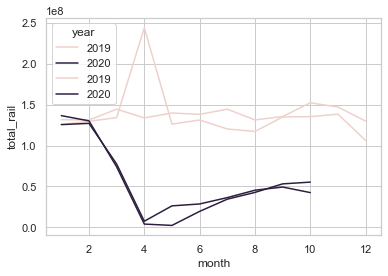

In [54]:
# Validate against Tfl Journeys trips
# For the most part, our transformed data is in the same order of magnitude as TfL journeys, the greatest difference
# is April 2019, which may be driven by double-counting of a reporting period that starts and ends in April.

tfljourneys['total_rail'] = tfljourneys['underground'] + tfljourneys['rail'] + tfljourneys['overground']

df = tfljourneys[(tfljourneys['year']>=2019)&(tfljourneys['year']<2021)].groupby(['year','month'])['total_rail'].agg('sum').reset_index()
df2 = tubetaps_final[tubetaps_final['year']>=2019].groupby(['year', 'month'])['origin_trips'].agg('sum').reset_index()
df_check = []
df_check = df.merge(df2, left_on = ['year', 'month'], right_on = ['year', 'month'])
#df_check

sns.lineplot(x = 'month', y = 'total_rail', data = df_check, ci = None, legend = True, hue = 'year')
sns.lineplot(x = 'month', y = 'origin_trips', data = df_check, ci = None, legend = True, hue = 'year')


In [49]:
df_check

,year,month,total_rail,origin_trips
0,2019,1,"125,762,235.01","131,632,394.00"
1,2019,2,"129,615,387.07","131,142,548.00"
2,2019,3,"134,101,950.59","144,434,034.00"
3,2019,4,"244,104,207.52","133,822,431.00"
4,2019,5,"126,145,795.91","139,784,477.00"
5,2019,6,"131,205,840.11","138,110,987.00"
6,2019,7,"120,195,763.19","144,447,238.00"
7,2019,8,"117,175,417.80","131,303,380.00"
8,2019,9,"134,923,994.62","135,467,838.00"
9,2019,10,"135,286,416.92","152,263,637.00"


In [6]:
bustaps['DATE'] = pd.to_datetime(bustaps['DATE'])
bustaps = bustaps.merge(calendar, left_on = 'DATE', right_on = 'date')
bustaps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1154621 entries, 0 to 1154620
Data columns (total 14 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Unnamed: 0     1154621 non-null  int64         
 1   DATE           1154621 non-null  datetime64[ns]
 2   MSOA11CD       1154621 non-null  object        
 3   MSOA11NM       1154621 non-null  object        
 4   LAD11CD        1154621 non-null  object        
 5   LAD11NM        1154621 non-null  object        
 6   origin_alight  1154621 non-null  float64       
 7   date           1154621 non-null  datetime64[ns]
 8   day            1154621 non-null  int64         
 9   weekday        1154621 non-null  object        
 10  month          1154621 non-null  int64         
 11  week           1154621 non-null  object        
 12  year           1154621 non-null  int64         
 13  week_beg       1154621 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), 

<AxesSubplot:xlabel='month', ylabel='bus'>

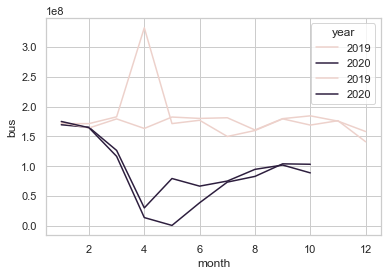

In [53]:
# Validate against Tfl Journeys trips
# For the most part, our transformed data is in the same order of magnitude as TfL journeys, the greatest difference
# is April 2019, which may be driven by double-counting of a reporting period that starts and ends in April.

df = tfljourneys[(tfljourneys['year']>=2019)&(tfljourneys['year']<2021)].groupby(['year','month'])['bus'].agg('sum').reset_index()
df2 = bustaps[bustaps['year']>=2019].groupby(['year', 'month'])['origin_alight'].agg('sum').reset_index()
df_check = []
df_check = df.merge(df2, left_on = ['year', 'month'], right_on = ['year', 'month'])
#df_check

sns.lineplot(x = 'month', y = 'bus', data = df_check, ci = None, legend = True, hue = 'year')
sns.lineplot(x = 'month', y = 'origin_alight', data = df_check, ci = None, legend = True, hue = 'year')

In [52]:
df_check

,year,month,bus,origin_alight
0,2019,1,"171,335,332.28","173,391,989.00"
1,2019,2,"171,305,577.60","163,996,292.00"
2,2019,3,"182,739,445.46","179,241,563.00"
3,2019,4,"331,884,717.26","163,280,752.00"
4,2019,5,"171,380,017.86","182,360,940.00"
5,2019,6,"176,958,605.72","180,066,621.00"
6,2019,7,"149,823,236.67","181,170,756.00"
7,2019,8,"159,778,183.14","160,710,965.00"
8,2019,9,"179,309,296.51","179,683,823.00"
9,2019,10,"168,908,631.41","184,368,444.00"


In [59]:
tubetaps_final.head()

,travel_location,master_nlc,travel_date,origin_trips,destination_trips,geometry,date,day,weekday,month,week,week_beg,year,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM
0,Tooting Bec,726.00,2016-02-19,"12,341.00","10,723.00",POINT (528018.814 172340.590),2016-02-19,19,Friday,2,07,2016-02-15,2016,E02000951,Wandsworth 029,E09000032,Wandsworth
971,Tooting Bec,726.00,2016-03-13,"5,865.00","6,102.00",POINT (528018.814 172340.590),2016-03-13,13,Sunday,3,10,2016-03-07,2016,E02000951,Wandsworth 029,E09000032,Wandsworth
1743,Tooting Bec,726.00,2015-11-11,"12,584.00","11,744.00",POINT (528018.814 172340.590),2015-11-11,11,Wednesday,11,45,2015-11-09,2015,E02000951,Wandsworth 029,E09000032,Wandsworth
2339,Tooting Bec,726.00,2015-07-24,"11,154.00","9,773.00",POINT (528018.814 172340.590),2015-07-24,24,Friday,7,29,2015-07-20,2015,E02000951,Wandsworth 029,E09000032,Wandsworth
2806,Tooting Bec,726.00,2015-11-13,"12,887.00","11,199.00",POINT (528018.814 172340.590),2015-11-13,13,Friday,11,45,2015-11-09,2015,E02000951,Wandsworth 029,E09000032,Wandsworth


In [61]:
# Export processed dataset for future analysis.
tubetaps_final.to_csv('output_data/tubetaps_final.csv',index=False)

In [7]:
# Export bus data
bustaps.to_csv('output_data/bustaps_final.csv', index=False)